# MinHash signatures - some properties on RNAseq

In [1]:
%matplotlib inline

In [2]:
import numpy
import sys
sys.path.append('../')
import sourmash_lib
import sourmash_signature as sig

## Utility functions

In [3]:
import glob
def load_series(globname):
    "Load a series of signatures, sampled while loading from a stream of reads"
    filelist = glob.glob(globname)
    xlist = []
    for name in filelist:
        n = int(name.split('.')[-1])
        if n % 1000000 != 0:
            continue
        data = open(name).read()
        s = sig.load_signatures(data, select_ksize=32)
        assert len(s) == 1
        s = s[0]
        s.estimator._truncate(500)
        xlist.append((n, s))
    xlist.sort()
    return xlist

In [4]:
house1 = load_series('SRR2060939_1.fastq.gz.trimnoV.fq.gz.sig.*')

In [5]:
house2 = load_series('SRR2060939_2.fastq.gz.trimnoV.fq.gz.sig.*')

In [6]:
disease1 = load_series('SRR2241509_1.fastq.gz.trimnoV.fq.gz.sig.*')

In [7]:
disease2 = load_series('SRR2255622_1.fastq.gz.trimnoV.fq.gz.sig.*')

In [8]:
yeast1 = load_series('SRR453566_1.fastq.gz.trimnoV.fq.gz.sig.*')
yeast2 = load_series('SRR453569_1.fastq.gz.trimnoV.fq.gz.sig.*')
yeast3 = load_series('SRR453570_1.fastq.gz.trimnoV.fq.gz.sig.*')

In [9]:
print(len(house1))
print(len(house2))
print(len(disease1))
print(len(disease2))
print(len(yeast1))
print(len(yeast2))
print(len(yeast3))

33
31
35
38
5
3
6


In [10]:
# make sure the samples were collected at same distance. note: data sets with more points
# get truncated by zip.
for (n1, sig1), (n2, sig2) in zip(house1, house2):
    assert n1 == n2
for (n1, sig1), (n3, sig3) in zip(house1, disease1):
    assert n1 == n3
for (n4, sig4), (n6, sig6) in zip(yeast1, yeast3):
    assert n4 == n6

## how do mouse data sets converge w/more reads?

Conclusion: you get > 1% similarity even w/in first m reads; data streams generally converge in MinHash similarity.

In [11]:
x1 = [ n1 for (n1, sig1), (n2, sig2) in zip(house1, house2) ]
y1 = [ sig1.similarity(sig2) for (n1, sig1), (n2, sig2) in zip(house1, house2) ]

In [12]:
x2 = [ n1 for (n1, sig1), (n3, sig3) in zip(house1, disease1) ]
y2 = [ sig1.similarity(sig3) for (n1, sig1), (n3, sig3) in zip(house1, disease1) ]

x3 = [ n1 for (n1, sig1), (n2, sig2) in zip(disease1, disease2) ]
y3 = [ sig1.similarity(sig2) for (n1, sig1), (n2, sig2) in zip(disease1, disease2) ]


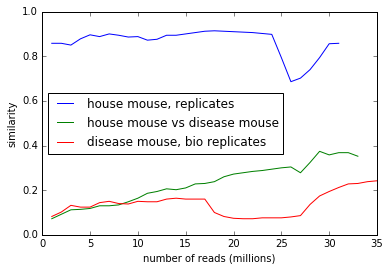

In [23]:
from matplotlib import pylab
pylab.plot(numpy.array(x1) / 1e6, y1, label='house mouse, replicates')
pylab.plot(numpy.array(x2) / 1e6, y2, label='house mouse vs disease mouse')
pylab.plot(numpy.array(x3) / 1e6, y3, label='disease mouse, bio replicates')

pylab.axis(ymin=0, ymax=1)
pylab.legend(loc='center left')
pylab.xlabel('number of reads (millions)')
pylab.ylabel('similarity')
pylab.savefig('sourmash-mouse-replicates.png')

## how do yeast data sets converge w/more reads?

Conclusion: you get very high similarity in yeast replicate conditions.

In [14]:
x4 = [ n4 for (n4, sig4), (n6, sig6) in zip(yeast1, yeast2) ]
y4 = [ sig4.similarity(sig6) for (n4, sig4), (n6, sig6) in zip(yeast1, yeast2) ]

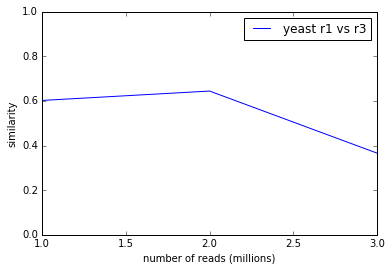

In [24]:
pylab.plot(numpy.array(x4)/1e6, y4, label='yeast r1 vs r3')
pylab.axis(ymin=0, ymax=1)
pylab.legend(loc='upper right')
pylab.xlabel('number of reads (millions)')
pylab.ylabel('similarity')
pylab.savefig('sourmash-yeast-replicates.png')

## A significant part of the mouse stream similarity is due to "real" sequence

Conclusion: growing similarity between mouse data streams is at least partly because we see growing similarity between mouse data streams and mouse reference transcriptome.


In [16]:
siglist = sig.load_signatures(open('../species/m_musculus.sig').read(), select_ksize=32)
assert len(siglist) == 1
ref = siglist[0]

In [17]:
x1r = [ n for (n, s) in disease1 ]
y1r = [ s.similarity(ref) for (n, s) in disease1 ]

In [18]:
x2r = [ n for (n, s) in house1 ]
y2r = [ s.similarity(ref) for (n, s) in house1 ]

In [19]:
x3r = [ n for (n, s) in yeast1 ]
y3r = [ s.similarity(ref) for (n, s) in yeast1 ]

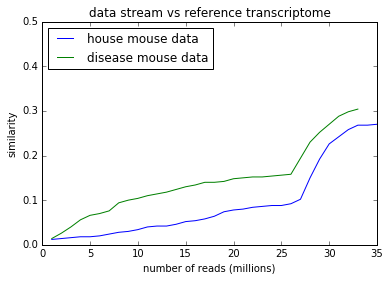

In [25]:
pylab.plot(numpy.array(x1r) / 1e6, y1r, label='house mouse data')
pylab.plot(numpy.array(x2r) / 1e6, y2r, label='disease mouse data')

pylab.axis(ymin=0, ymax=0.5)
pylab.xlabel('number of reads (millions)')
pylab.ylabel('similarity')
pylab.title('data stream vs reference transcriptome')
pylab.legend(loc='upper left')
pylab.savefig('sourmash-mouse-reads-v-ref.png')


## ...but yeast and mouse share no similarity.

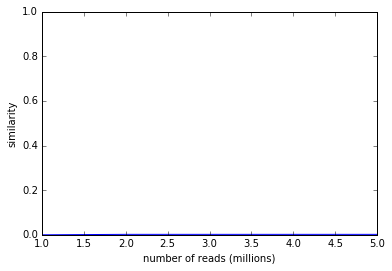

In [26]:
pylab.plot(numpy.array(x3r) / 1e6, y3r, label='yeast data vs mouse ref')
pylab.axis(ymin=0, ymax=1)

pylab.xlabel('number of reads (millions)')
pylab.ylabel('similarity')
pylab.savefig('sourmash-yeast-vs-mouse.png')

In [22]:
# there is 0.2% similarity between the yeast data stream and mouse transcriptome:
max(y3r)

0.002